In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from glob import glob
from collections import defaultdict

from lib import LogTorPSMultiple
from lib import Log
from lib import Simulation
from lib import Consensus

from lib import ACTIVE_CIRCUITS_PER_SECOND
from lib import ACTIVE_CIRCUITS_PER_SECOND_STD

In [2]:
web=[(80,80),(443, 443)]
btb=[(6881,6889)]
bte=[(6890,6999)]
ofs=[(1214,1214),(4661,4666),(6346,6429),(6699,6699)]
var=[(25,25),(119,119),(135,139),(445,445),(563,563)]

web_table = [
    # ('strict', 56_315),
    ('default', web, 1_415_683),
    ('fs', web + ofs, 1_129_056),
    ('fs+', web + ofs + bte,  1_608_116),
    ('fs++', web + ofs + bte + btb, 1_467_024),
    ('open', web + ofs + bte + btb + var,1_422_420),
]

other_table = [
    # ('strict', 397_979),
    ('default', web, 490_744),
    ('fs', web + ofs, 1_126_731),
    ('fs+', web + ofs + bte, 4_927_450),
    ('fs++', web + ofs + bte + btb, 3_513_119),
    ('open', web + ofs + bte + btb + var, 1_890_266),
]

web_circuits = sum([v for k,p,v in web_table])
other_circuits = sum([v for k,p,v in other_table])

other_circuits/web_circuits

1.6966490630403508

In [3]:
def simulate_mixture(consensus_filename, N, directed_links):
    ratio = (other_circuits / web_circuits)
    external_web_circuits = round(N / (ratio + 1.0))
    external_other_circuits  = round(N / (ratio + 1.0) * ratio)
    
    sims = []
    
    consensus_web = Consensus.read(consensus_filename, filter_by_exit_port_ranges=None)
    sims.append(Simulation.from_consensus(consensus_web, N=external_web_circuits).simulate())
    
    total = 0
    for (label, ports, weigth) in other_table:
        consensus_port = Consensus.read(
            consensus_filename,
            filter_by_exit_port_ranges=ports
        )

        n = weigth / other_circuits * external_other_circuits
        total += round(n)

        sims.append(Simulation.from_consensus(consensus_port, N=round(n), directed_links=directed_links).simulate())
    
    assert total == external_other_circuits
    
    return Simulation.merge(sims)

simulate_mixture(
    '../archive/in/consensuses-2021-11/01/2021-11-01-00-00-00-consensus', 
    N=ACTIVE_CIRCUITS_PER_SECOND, 
    directed_links=True
).stat.create_table().T

Date                                        None
Total Circuits                      96876.000000
Total Links                        175265.000000
Shared Links                        12939.000000
Unshared Links                     162326.000000
Shared Links Percent                    7.382535
Total Circuit Parts                193752.000000
Shared Circuit Parts                31426.000000
Unshared Circuit Parts             162326.000000
Shared Circuit Parts Percent           16.219704
Total Guard-Middle Links            94103.000000
Shared Guard-Middles Links           2624.000000
Unshared Guard-Middles Links        91479.000000
Shared Guard-Middles Percent            2.788434
Total Middle-Exits Links            81162.000000
Shared Middle-Exits Links           10315.000000
Unshared Middle-Exits Links         70847.000000
Shared Middle-Exits Links Percent      12.709150
Complete Shared Circuits               25.000000
Relays                               5493.000000
Guards                               2317.000000
Middles                              4255.000000
Exits                                1231.000000

In [4]:
groups = {
    'Web': None,
    'Mixture': None,
    'BitTorrent Base': [(6881,6889)],
    'BitTorrent Extended': [(6890,6999)],
    'Other File-Sharing': [(1214,1214),(4661,4666),(6346,6429),(6699,6699)],
    'Various': [(25,25),(119,119),(135,139),(445,445),(563,563)],
}

table = defaultdict(list)
for group in groups:
    for consensus in glob('./../archive/in/consensuses-2021-11/**/*-02-00-00-consensus'):
        for directed in [False, True]:
            try:
                c = Consensus.read(
                    consensus,
                    filter_by_exit_port_ranges=groups[group]
                )
            except Exception as e:
                print(consensus, str(e))
                continue

            if group == 'Mixture':
                sim = simulate_mixture(consensus, N=ACTIVE_CIRCUITS_PER_SECOND, directed_links=directed)                
            else:
                sim = Simulation.from_consensus(c, N=ACTIVE_CIRCUITS_PER_SECOND, directed_links=directed).simulate()
                            
            table['consensus'].append(consensus)
            table['group'].append(group)
            table['directed'].append(directed)
            table['shared'].append(float(sim.stat.create_table()['Shared Links Percent']))
            table['guards'].append(len(c.guards()))
            table['middles'].append(len(c.middles())) 
            table['exits'].append(len(c.exits()))                    
            
table = pd.DataFrame(table)
table

consensus    group  directed  \
0    ./../archive/in/consensuses-2021-11/13/2021-11...      Web     False   
1    ./../archive/in/consensuses-2021-11/13/2021-11...      Web      True   
2    ./../archive/in/consensuses-2021-11/02/2021-11...      Web     False   
3    ./../archive/in/consensuses-2021-11/02/2021-11...      Web      True   
4    ./../archive/in/consensuses-2021-11/25/2021-11...      Web     False   
..                                                 ...      ...       ...   
355  ./../archive/in/consensuses-2021-11/01/2021-11...  Various      True   
356  ./../archive/in/consensuses-2021-11/10/2021-11...  Various     False   
357  ./../archive/in/consensuses-2021-11/10/2021-11...  Various      True   
358  ./../archive/in/consensuses-2021-11/07/2021-11...  Various     False   
359  ./../archive/in/consensuses-2021-11/07/2021-11...  Various      True   

        shared  guards  middles  exits  
0     4.715049    2365     4807   1288  
1     4.151159    2365     4807   1288  
2     4.265057    2449     5429   1294  
3     3.790450    2449     5429   1294  
4     4.562991    2456     4879   1434  
..         ...     ...      ...    ...  
355  15.164303    2320     5320     80  
356  16.592462    2368     4823     40  
357  15.804843    2368     4823     40  
358  15.199004    2454     5370     40  
359  14.704729    2454     5370     40  

[360 rows x 7 columns]

In [5]:
table.groupby(['group', 'directed']).agg(['mean'])

/tmp/ipykernel_1594117/2290869084.py:1: FutureWarning: ['consensus'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  table.groupby(['group', 'directed']).agg(['mean'])


shared  guards middles        exits
                                   mean    mean    mean         mean
group               directed                                        
BitTorrent Base     False     11.600916  2427.6  5006.2   198.233333
                    True      11.016853  2427.6  5006.2   198.233333
BitTorrent Extended False     11.502692  2427.6  5006.2   200.233333
                    True      10.918959  2427.6  5006.2   200.233333
Mixture             False      6.705026  2427.6  5006.2  1348.000000
                    True       6.693030  2427.6  5006.2  1348.000000
Other File-Sharing  False     11.487826  2427.6  5006.2   200.833333
                    True      10.936846  2427.6  5006.2   200.833333
Various             False     16.547285  2427.6  5006.2    44.166667
                    True      15.843506  2427.6  5006.2    44.166667
Web                 False      4.551563  2427.6  5006.2  1348.000000
                    True       4.069104  2427.6  5006.2  1348.000000

In [6]:
table.groupby(['group']).agg(['mean'])

/tmp/ipykernel_1594117/1234433096.py:1: FutureWarning: ['consensus'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  table.groupby(['group']).agg(['mean'])


directed     shared  guards middles        exits
                        mean       mean    mean    mean         mean
group                                                               
BitTorrent Base          0.5  11.308884  2427.6  5006.2   198.233333
BitTorrent Extended      0.5  11.210826  2427.6  5006.2   200.233333
Mixture                  0.5   6.699028  2427.6  5006.2  1348.000000
Other File-Sharing       0.5  11.212336  2427.6  5006.2   200.833333
Various                  0.5  16.195395  2427.6  5006.2    44.166667
Web                      0.5   4.310333  2427.6  5006.2  1348.000000

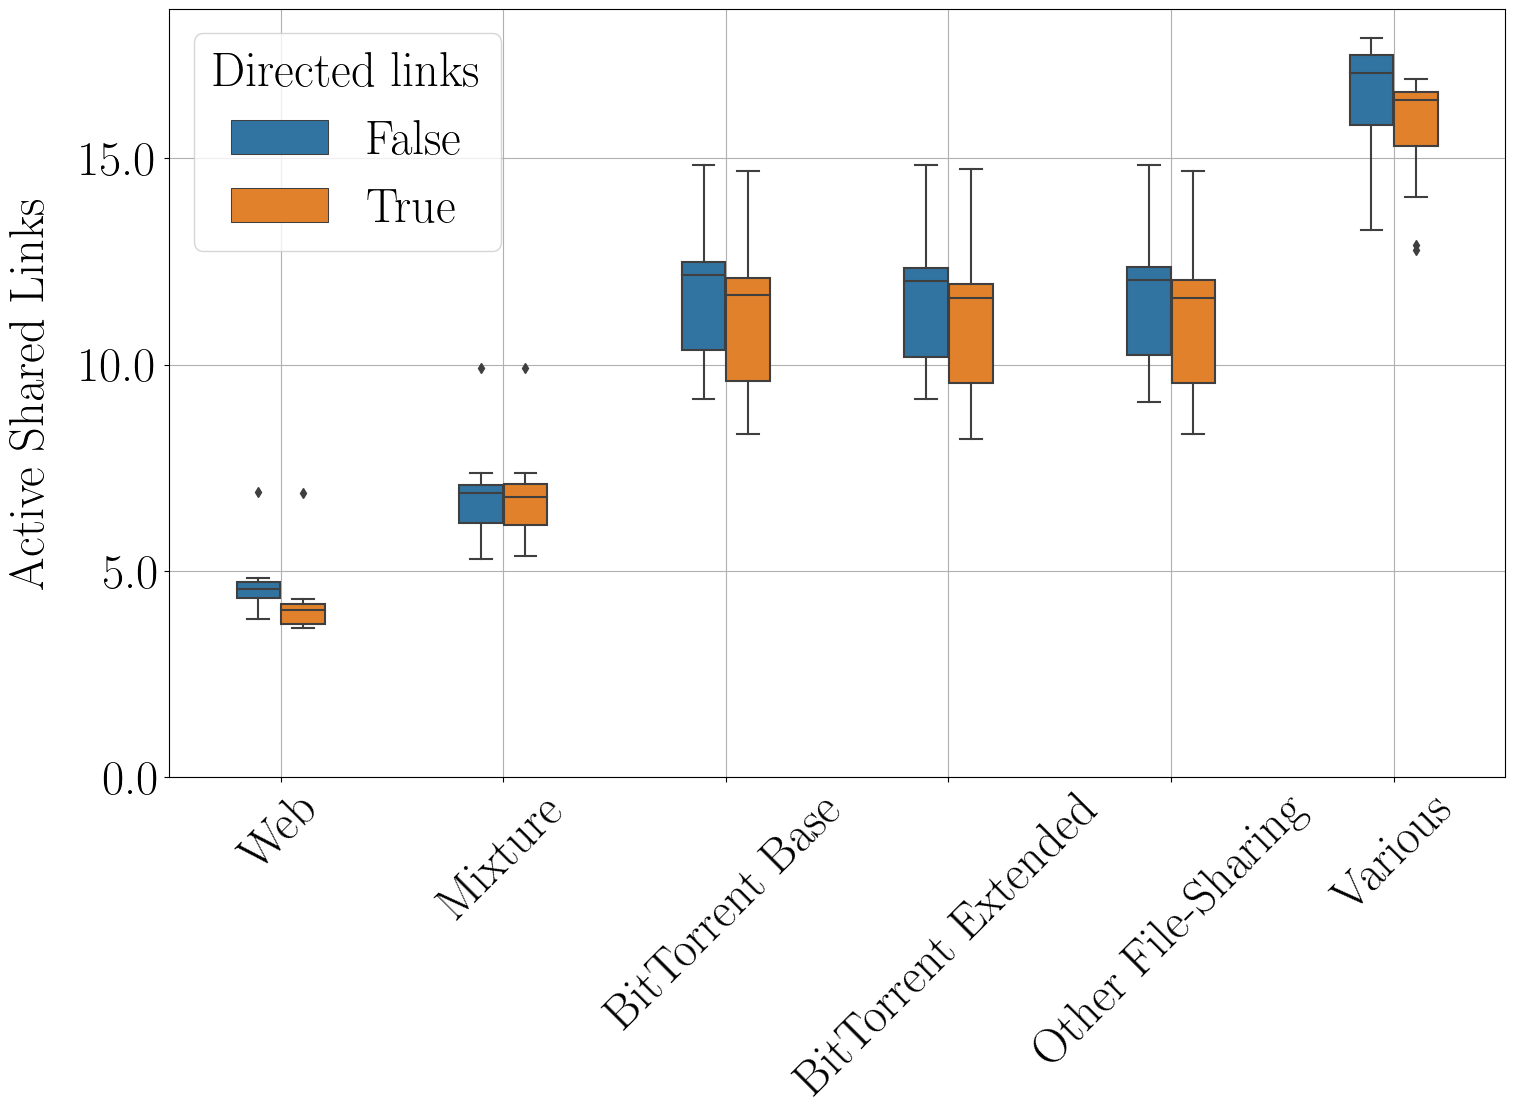

In [7]:
plt.rc('font', family='cmr10')
plt.rc('font', size=35)
plt.rc('axes', axisbelow=True)
plt.rc('axes.formatter', use_mathtext=True)

def format_percent(x, pos=None, digits=1, xmax=100):
    x = x / xmax * 100
    format_string = '%%.%df %%%%' % digits
    return format_string % x

import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

plt.figure(figsize=(16, 12))
sns.boxplot(x='group', y='shared', hue='directed', width=0.4, data=table)
plt.gca().yaxis.set_major_formatter(format_percent)
plt.xlabel(None)
plt.ylabel('Active Shared Links', labelpad=20)
plt.ylim(0)
plt.gca().grid(True)
plt.tick_params(axis='x', labelrotation=45)
l = plt.legend()
l.set_title('Directed links')
plt.tight_layout()
plt.savefig('paper-exit-policy.pdf')
plt.show()